# Klasyfikator statków powietrznych - Szymon Derlecki

In [18]:
!pip install imbalanced-learn
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable


# **Import pakietów**

In [1]:
import os
import cv2
import random
import seaborn as sns
import pandas as pd
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
#from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# **Wczytanie danych**

In [2]:
#pics = od.download("https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset")

In [3]:
data = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/crop"

# **Uzyskanie klas samolotów i przedstawienie ich na wykresie**

In [4]:
def get_classes(data):
    lst = []
    for root, plane_type, photos in os.walk(data):
        lst.extend(plane_type)
        num = len(lst)
        break
    return lst, num

In [5]:
print(get_classes(data))

(['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C2', 'C5', 'E2', 'E7', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'Mig31', 'Mirage2000', 'MQ9', 'P3', 'Rafale', 'RQ4', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan', 'XB70', 'YF23'], 43)


In [6]:
def count_image_per_class(data):
    labels = os.walk(data)
    counts = {}
    for root, plane_types, photos in labels:
        for plane_type in plane_types:
            type_path = os.path.join(root, plane_type)
            count = 0
            for dirpath, dirname, file in os.walk(type_path):
                count += len(file)
            counts[plane_type] = count
    return counts

In [7]:
summary = count_image_per_class(data)
summary

{'A10': 545,
 'A400M': 295,
 'AG600': 178,
 'AV8B': 350,
 'B1': 503,
 'B2': 398,
 'B52': 419,
 'Be200': 228,
 'C130': 723,
 'C17': 400,
 'C2': 422,
 'C5': 306,
 'E2': 337,
 'E7': 36,
 'EF2000': 442,
 'F117': 284,
 'F14': 415,
 'F15': 991,
 'F16': 1028,
 'F18': 1033,
 'F22': 510,
 'F35': 852,
 'F4': 473,
 'J20': 439,
 'JAS39': 423,
 'Mig31': 283,
 'Mirage2000': 334,
 'MQ9': 249,
 'P3': 13,
 'Rafale': 411,
 'RQ4': 263,
 'SR71': 234,
 'Su34': 250,
 'Su57': 285,
 'Tornado': 331,
 'Tu160': 235,
 'Tu95': 219,
 'U2': 229,
 'US2': 531,
 'V22': 683,
 'Vulcan': 291,
 'XB70': 146,
 'YF23': 128}

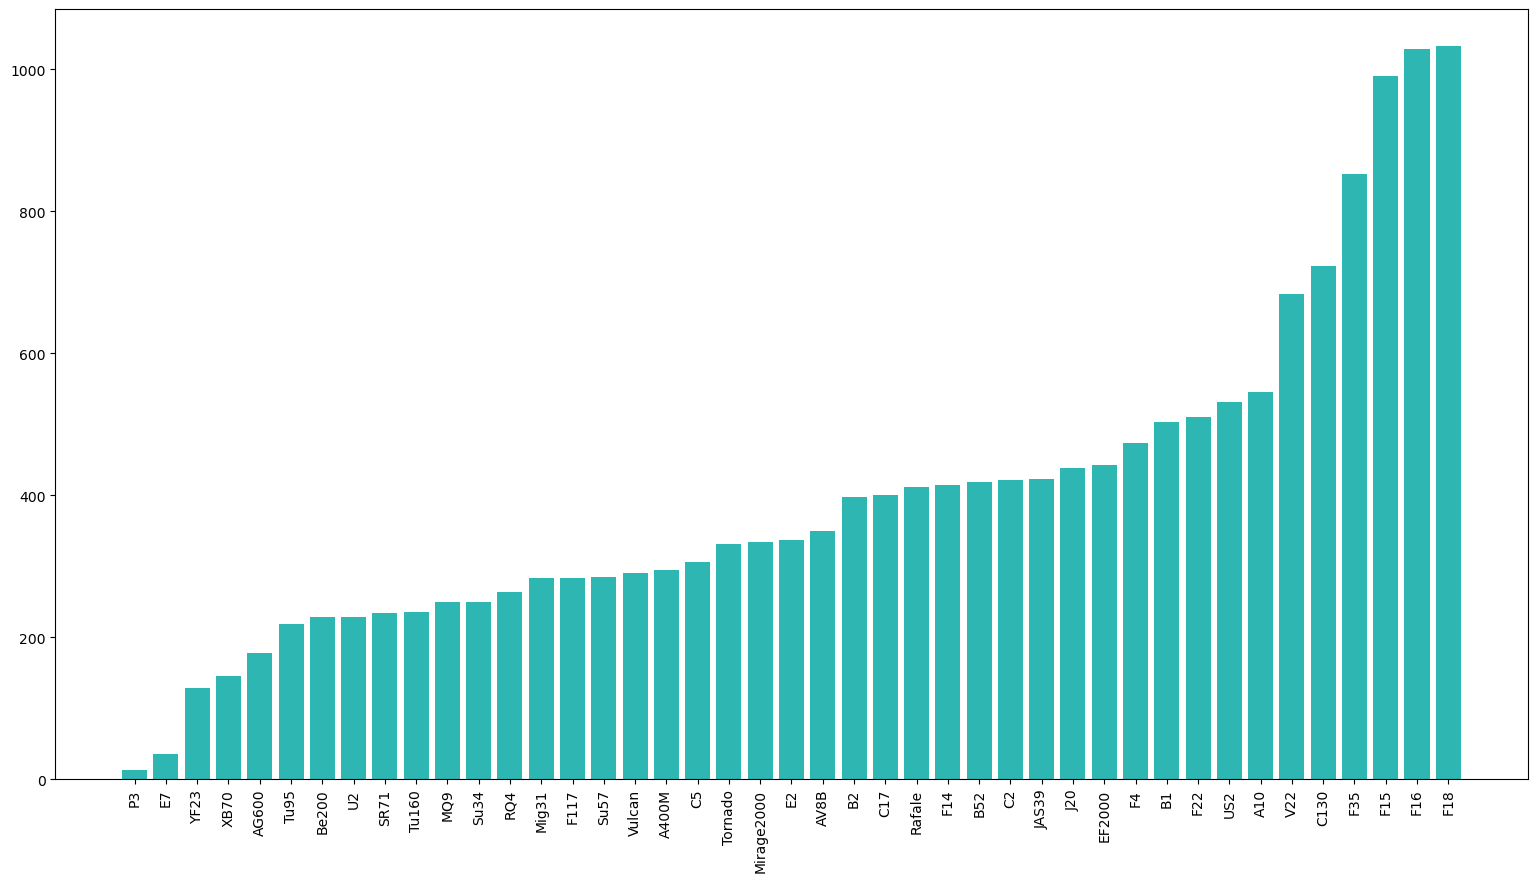

In [8]:
counts = count_image_per_class(data)

types = list(counts.keys())
values = list(counts.values())

sorted_indices = sorted(range(len(values)), key=lambda k: values[k])
types = [types[i] for i in sorted_indices]
values = [values[i] for i in sorted_indices]

plt.figure(figsize=(19, 10))
plt.bar(range(len(types)), values, tick_label = types, color = "#2eb6b3")
plt.xticks(rotation = 90)
plt.show()

# Kod do normalizacji

In [9]:
def normal_and_save(data):
    output_file = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/normal"
    os.makedirs(output_file, exist_ok=True)
    normalized_files = []

    for root, plane_type, photos in os.walk(data):
        for photo in photos:
            photo_path = os.path.join(root, photo)
            image = Image.open(photo_path).convert("RGB")
            size = (224, 224)
            image_res = np.array(image.resize(size)) / 225

            rel_path = os.path.relpath(root, data)
            output_plane_type = os.path.join(output_file, rel_path)
            os.makedirs(output_plane_type, exist_ok=True)
            
            output_path = os.path.join(output_plane_type, photo)
            Image.fromarray((image_res * 225).astype(np.uint8)).save(output_path)
            normalized_files.append(output_path)

    return normalized_files

In [57]:
#normal_and_save(data)

# Wyświetlenie przykładowego zdjęcia po normalizacji

In [10]:
def show_img(data):
    start_path = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/normal"
    photo_paths = []

    for root, plane_types, photos in os.walk(start_path):
        for photo in photos:
            photo_path = os.path.join(root, photo)
            photo_paths.append(photo_path)

    if photo_paths:
        random_photo = random.choice(photo_paths)
        random_img = mpimg.imread(random_photo) 
        plt.imshow(random_img)
        return random_photo

'C:/Users/szymo/Desktop/dane_do_pracy_dyp/normal\\Mirage2000\\b0aa6f15e9602b69a098c34a46443142_9.jpg'

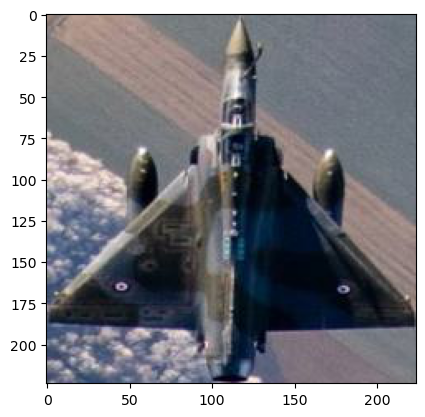

In [11]:
data = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/normal"
show_img(data)

# Podział

In [12]:
def splitdata(normalized_folder, train_ratio=0.8, random_seed=42):
    data = []
    
    for plane_type in os.listdir(normalized_folder):
        plane_type_folder = os.path.join(normalized_folder, plane_type)
        for file_name in os.listdir(plane_type_folder):
            file_path = os.path.join(plane_type_folder, file_name)
            data.append({'Path': file_path, 'Plane Type': plane_type})

    random.seed(random_seed)
    random.shuffle(data)

    data_frame = pd.DataFrame(data)

    train_data = data_frame.sample(frac=train_ratio, random_state=random_seed)
    test_data = data_frame.drop(train_data.index)
    
    return train_data, test_data, data_frame

In [13]:
normalized_folder = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/normal"

In [14]:
train_data, test_data, complete_data = splitdata(normalized_folder, train_ratio=0.8, random_seed=42)

print("Train Dataset Size:", len(train_data))
print("Test Dataset Size:", len(test_data))
print("Complete Dataset Size:", len(complete_data))

Train Dataset Size: 13716
Test Dataset Size: 3429
Complete Dataset Size: 17145


In [15]:
complete_data.head()

,Path,Plane Type
0,C:/Users/szymo/Desktop/dane_do_pracy_dyp/norma...,Tu160
1,C:/Users/szymo/Desktop/dane_do_pracy_dyp/norma...,Mirage2000
2,C:/Users/szymo/Desktop/dane_do_pracy_dyp/norma...,F15
3,C:/Users/szymo/Desktop/dane_do_pracy_dyp/norma...,C130
4,C:/Users/szymo/Desktop/dane_do_pracy_dyp/norma...,B2


# Wczytywanie zdjęć do modelu

In [16]:
labels = pd.get_dummies(complete_data['Plane Type'])
input_shape = (224, 224, 3)

def load_image(path, input_shape):
    img = cv2.imread(path)
    img = cv2.resize(img, (input_shape[1], input_shape[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

x_train = np.array([load_image(path, input_shape) for path in train_data['Path']])
x_test = np.array([load_image(path, input_shape) for path in test_data['Path']])

y_train = labels.loc[train_data.index].values
y_test = labels.loc[test_data.index].values

# Oversampling

In [17]:
oversampler = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = oversampler.fit_resample(x_train.reshape(-1, np.prod(input_shape)), y_train)

x_train_resampled = x_train_resampled.reshape(-1, *input_shape)

resampled_classes = pd.Series(y_train_resampled.argmax(axis=1)).unique()
class_indices = {class_name: i for i, class_name in enumerate(resampled_classes)}

num_classes_resampled = pd.Series(y_train_resampled.argmax(axis=1)).value_counts()
total_samples_resampled = len(y_train_resampled)
class_weights_resampled = {class_indices[class_name]: total_samples_resampled / count for class_name, count in num_classes_resampled.items()}

# Stworzenie modelu

In [19]:
input_shape = (224, 224, 3)
num_classes = len(complete_data['Plane Type'].unique())

base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.01), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001), activation='relu'),
    Dropout(rate=0.43, seed=123),
    Dense(num_classes, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                11051     
                                                                 
Total params: 6,263,419
Trainable params: 6,200,251
No

# Trening sieci

In [20]:
model.fit(x_train_resampled, y_train_resampled, batch_size=16, epochs=10, validation_data=(x_test, y_test),
          class_weight=class_weights_resampled)

Epoch 1/10
2204/2204 [==============================] - 3013s 1s/step - loss: 77.5906 - accuracy: 0.5614 - val_loss: 5.4308 - val_accuracy: 0.7784
Epoch 2/10
2204/2204 [==============================] - 3009s 1s/step - loss: 23.8232 - accuracy: 0.8721 - val_loss: 5.2642 - val_accuracy: 0.8507
Epoch 3/10
2204/2204 [==============================] - 3028s 1s/step - loss: 14.1005 - accuracy: 0.9353 - val_loss: 5.2101 - val_accuracy: 0.8679
Epoch 4/10
2204/2204 [==============================] - 3288s 1s/step - loss: 10.2907 - accuracy: 0.9607 - val_loss: 5.1095 - val_accuracy: 0.8705
Epoch 5/10
2204/2204 [==============================] - 3122s 1s/step - loss: 8.4749 - accuracy: 0.9710 - val_loss: 4.8746 - val_accuracy: 0.8857
Epoch 6/10
2204/2204 [==============================] - 3092s 1s/step - loss: 7.3679 - accuracy: 0.9785 - val_loss: 4.6718 - val_accuracy: 0.8921
Epoch 7/10
2204/2204 [==============================] - 3095s 1s/step - loss: 6.5664 - accuracy: 0.9830 - val_loss: 4.47

# Predykcja

In [21]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

108/108 [==============================] - 64s 580ms/step


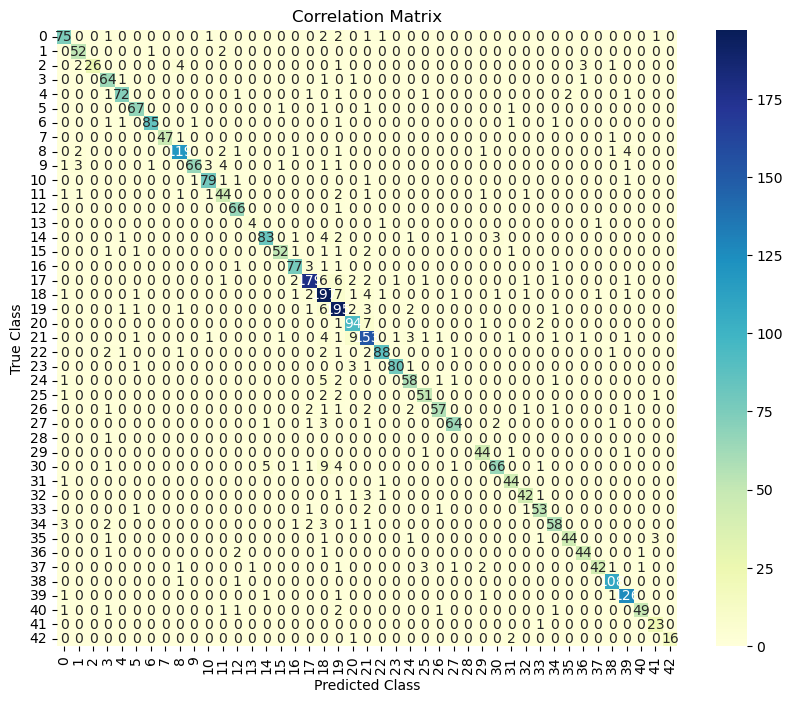

In [22]:
correlation_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Przedstawienie przykładowego zdjęcia ze zbioru

In [23]:
def show_random_img(data, model):
    start_path = data
    photo_paths = []

    for root, plane_type, photos in os.walk(start_path):
        for photo in photos:
            photo_path = os.path.join(root, photo)
            photo_paths.append(photo_path)

    if photo_paths:
        random_photo = random.choice(photo_paths)
        random_img = mpimg.imread(random_photo)

        input_shape = (224, 224, 3)
        img = cv2.imread(random_photo)
        img = cv2.resize(img, (input_shape[1], input_shape[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction)
        class_folder_mapping = {i: class_name for i, class_name in enumerate(labels.columns)}
        predicted_class_folder = class_folder_mapping[predicted_class_index]

        plt.imshow(random_img)
        plt.axis('off')
        plt.title(f"Predicted aircraft class: {predicted_class_folder}")
        plt.show()

        return predicted_class_folder
    else:
        return None

1/1 [==============================] - 0s 38ms/step


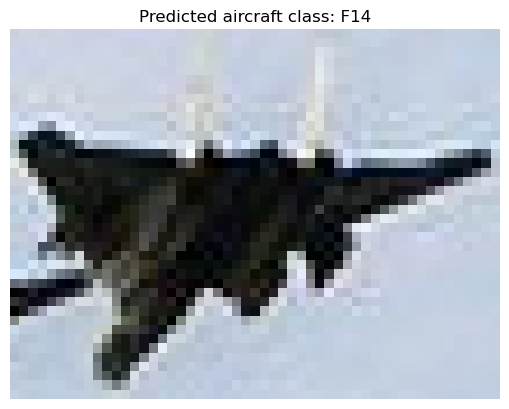

'F14'

In [56]:
data = "C:/Users/szymo/Desktop/dane_do_pracy_dyp/crop"
show_random_img(data, model)

# Przedstawienie przykładowego zdjęcia spoza zbioru

In [36]:
def show_your_img(image_path, model):
    input_shape = (224, 224, 3)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (input_shape[1], input_shape[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    class_folder_mapping = {i: class_name for i, class_name in enumerate(labels.columns)}
    predicted_class_folder = class_folder_mapping[predicted_class_index]

    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted aircraft class: {predicted_class_folder}")
    plt.show()

    return predicted_class_folder

1/1 [==============================] - 0s 45ms/step


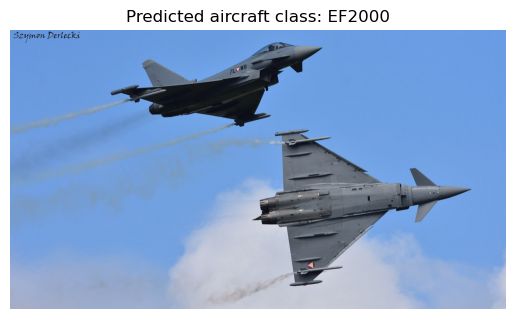

'EF2000'

In [64]:
path = "C:/Users/szymo/Desktop/foto_testowe_moje/typhs.jpg"
show_your_img(path, model)